In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        rand_start = np.random.rand(batch_size,1)
        ts_start = rand_start*(self.xmax - self.xmin - (steps*self.resolution))
        batch_ts = ts_start + np.arange(0.0,steps+1)*self.resolution
        y_batch = np.sin(batch_ts)
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1),batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = TimeSeriesData(250,0,10)

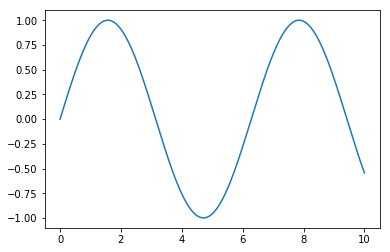

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps=30

In [6]:
y1,y2,ts=ts_data.next_batch(1,num_time_steps,True)

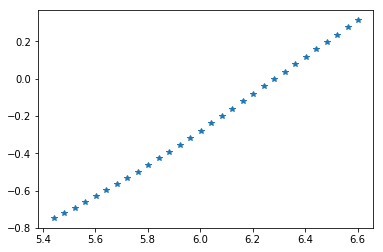

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

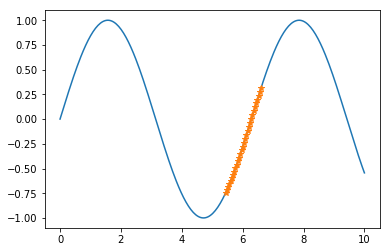

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*')


In [9]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

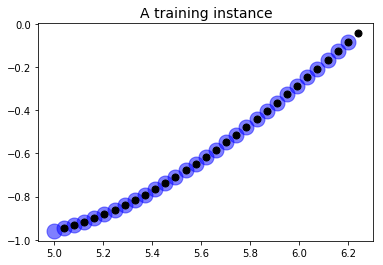

In [10]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

In [11]:
num_inputs = 1

In [12]:
num_neurons =100

In [13]:
num_outputs = 1

In [14]:
learning_rate = 0.0001

num_iterations = 2000

In [15]:
num_iterations = 2000

In [16]:
batch_size = 1

In [17]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])

In [18]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [19]:
#cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

In [20]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [21]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [23]:
train=optimizer.minimize(loss)

In [24]:
init = tf.global_variables_initializer()

In [25]:
saver = tf.train.Saver()

In [26]:
with tf.Session() as sess:
    sess.run(init)
    for itreration in range(num_iterations):
        X_batch,Y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:X_batch, y:Y_batch})
        if itreration %100==0:
            mse = loss.eval(feed_dict={X:X_batch,y:Y_batch})
            print(itreration,"\tMSE",mse)
    saver.save(sess,"./rnn")    

0 	MSE 0.12931027
100 	MSE 0.12470569
200 	MSE 0.05966388
300 	MSE 0.0449931
400 	MSE 0.02162744
500 	MSE 0.013164532
600 	MSE 0.023684742
700 	MSE 0.02675349
800 	MSE 0.019735675
900 	MSE 0.0020877204
1000 	MSE 0.0003020025
1100 	MSE 0.011920382
1200 	MSE 0.005962075
1300 	MSE 0.0031170922
1400 	MSE 0.0033772695
1500 	MSE 0.011187005
1600 	MSE 0.010403082
1700 	MSE 0.0023563604
1800 	MSE 0.0010592717
1900 	MSE 0.007170072


In [28]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn


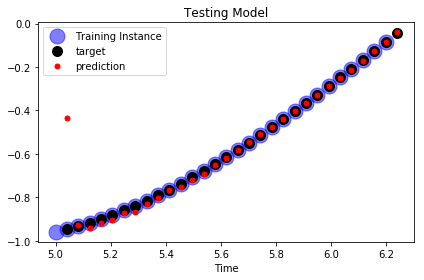

In [29]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()